In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [6]:
df_train = pd.read_csv('train_reg.csv')

In [7]:
x_train = df_train['x']
y_train = df_train['y']

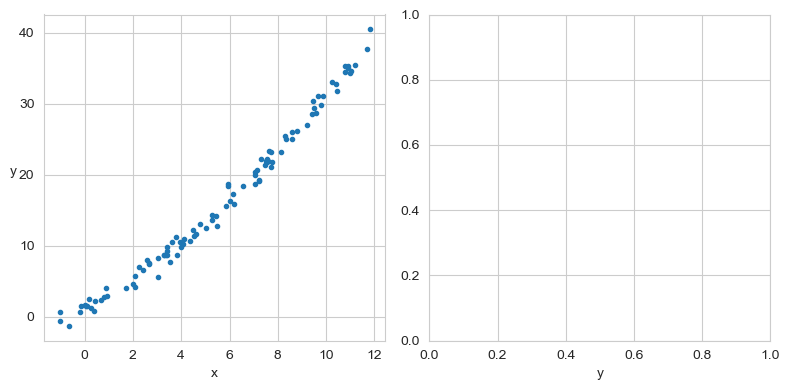

In [12]:
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x_train, y_train, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
#az.plot_kde(y_train, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout();

In [13]:
with pm.Model() as model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    ε = pm.HalfNormal('ε', 5)
    ν = pm.Gamma('ν', mu=10, sigma=0.1)

    x_shared = pm.MutableData('x_shared', x_train)

    y_pred = pm.StudentT('y_pred', mu=α_tmp + β * (x_shared - x_shared.mean()),
                         sigma=ε, nu=ν, observed=y_train)

    α = pm.Deterministic('α', α_tmp - β * x_shared.mean())

    trace = pm.sample(3000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, ε, ν]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 18 seconds.


In [14]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,16.146,0.173,15.822,16.474,0.001,0.001,21268.0,9711.0,1.0
β,3.091,0.052,2.990,3.185,0.000,0.000,18660.0,9850.0,1.0
ε,1.566,0.125,1.330,1.795,0.001,0.001,20034.0,9661.0,1.0
ν,10.001,0.099,9.820,10.189,0.001,0.001,17370.0,9377.0,1.0
α,-0.797,0.336,-1.421,-0.157,0.002,0.002,20261.0,9741.0,1.0


In [15]:
posterior_g = az.extract(trace)


alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(x_train, posterior_g['α'][draws].values +
                 posterior_g['β'][draws].values * x_train[:,None], c='gray', alpha=0.1)

plt.plot(x_train, alpha_m + beta_m * x_train, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
plt.scatter(x_train, y_train)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

всего трасс :  12000


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [16]:
x_test = pd.read_csv('test_reg.csv')['x']

In [17]:
pm.set_data({"x_shared":x_test}, model=model)
ppc = pm.sample_posterior_predictive(trace, model=model)
y_pred = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw")).values

Sampling: [y_pred]


In [18]:
y_pred.mean(axis=1)

array([17.74847114,  7.68410744, -2.60915939, 30.02798045, 21.78615343,
       22.36945424, 13.05724533, 25.6225026 , 28.41617968,  5.75383412,
        6.45478343, 28.74964172, 22.00728794,  9.91542179, 28.69304261,
       30.61430713, 17.94664558, 24.65340471, 17.70760839,  5.27808918,
       24.96093241,  7.46472885, 24.40686639, 21.32562954, 10.81781898,
        8.08450392, 14.15886636, 14.16249834, 21.92187458, 24.36442057,
        2.01304088,  1.51485507,  8.60096507, 11.54851992, 21.52759354,
       21.39054207, 21.92314328, 20.95187116, 29.00236729,  6.67420689,
        7.89057381, 38.91514803,  8.50089446,  1.32823672, 21.0154977 ,
       34.07985037,  2.64422368,  1.47653074, 25.5954672 , 15.74668866,
       18.00189844, 25.45510808, -0.89393992, 21.39905986, 11.20163355,
       12.26874763, 20.60381886, 18.47403646, 29.84000695, 14.62549505,
       28.44481985, 17.2864628 ,  2.91134551,  2.00047356,  6.76733145,
       13.69194947,  4.34867673, 34.56738587, 15.78849927, 23.13

In [21]:
from sklearn.metrics import mean_squared_error
y_true = pd.read_csv('test_Y_true_reg.csv')
mean_squared_error(y_true, y_pred.mean(axis=1))

2.4692245513118767